In [8]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.integrate import odeint
import lmfit

In [9]:
sns.set()
%matplotlib inline

In [10]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
%autoreload 2

In [12]:
from sir_models.seir_two_stain import SEIRTwoStain
from sir_models.utils import stepwise

# Load data

In [13]:
df = pd.read_csv('data/data.csv', sep=';')

In [14]:
df.columns = ['date', 'region', 'total_infected', 'total_recovered', 'total_dead', 'deaths_per_day', 'infected_per_day', 'recovered_per_day']
df['date'] = pd.to_datetime(df['date'], format='%d.%m.%Y')

df['infected'] = df['total_infected'] - df['total_recovered'] - df['total_dead']

In [15]:
df = df[df.region == 'Москва'].reset_index()
#df = df.groupby('date').sum().reset_index()

In [16]:
df.head()

,index,date,region,total_infected,total_recovered,total_dead,deaths_per_day,infected_per_day,recovered_per_day,infected
0,40,2020-03-12,Москва,21,0,0,0,21,0,21
1,122,2020-03-13,Москва,26,0,0,0,5,0,26
2,204,2020-03-14,Москва,35,0,0,0,9,0,35
3,286,2020-03-15,Москва,35,1,0,0,0,1,34
4,368,2020-03-16,Москва,53,1,0,0,18,0,52


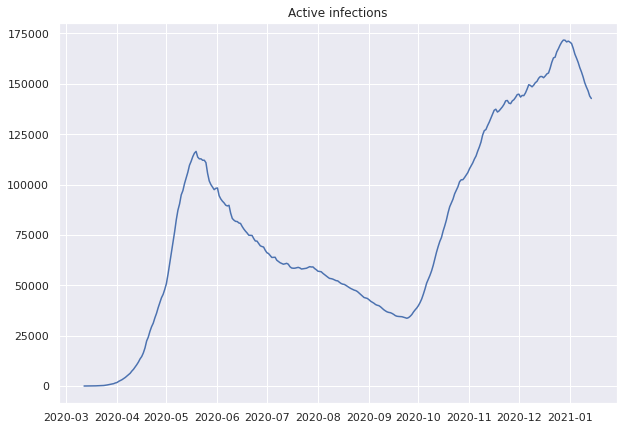

In [17]:
plt.figure(figsize=(10,7))
plt.plot(df.date, df.infected)
plt.title("Active infections")
plt.show()

# Future forecast

In [79]:
future_dates = pd.date_range(start=df.iloc[-1].date, periods=365//2)[1:]
future_t = np.arange(train_t[-1]+1, train_t[-1]+1+len(future_dates))

assert len(future_dates) == len(future_t)

In [80]:
future_dates

DatetimeIndex(['2021-01-15', '2021-01-16', '2021-01-17', '2021-01-18',
               '2021-01-19', '2021-01-20', '2021-01-21', '2021-01-22',
               '2021-01-23', '2021-01-24',
               ...
               '2021-07-05', '2021-07-06', '2021-07-07', '2021-07-08',
               '2021-07-09', '2021-07-10', '2021-07-11', '2021-07-12',
               '2021-07-13', '2021-07-14'],
              dtype='datetime64[ns]', length=181, freq='D')

In [81]:
from lmfit import Parameters

In [91]:
params = Parameters()
params.add("base_population", value=12_000_000, vary=False)
params.add("pre_existing_immunity", value=0.1806, vary=False)
params.add("sus_population", expr='base_population - base_population * pre_existing_immunity', vary=False)
params.add("r0_1", value=3.55, vary=False)
params.add("new_stain_mult", value=1.5, vary=False)
params.add("r0_2", expr='r0_1 * new_stain_mult', vary=False)

params.add(f"t0_q", value=0.6, min=0, max=0.99, brute_step=0.1, vary=False)     

params.add("delta", value=1/5.15, vary=False) # E -> I rate
params.add("alpha", value=0.0066, min=0.0066, max=0.05, vary=False) # Probability to die if infected
params.add("gamma", value=1/3.5, vary=False) # I -> R rate
params.add("rho", value=1/14, vary=False) # I -> D rate

model = SEIRTwoStain(params=params)

In [92]:
df.iloc[-1]

index                              26204
date                 2021-01-14 00:00:00
region                            Москва
total_infected                    877428
total_recovered                   722487
total_dead                         12241
deaths_per_day                        68
infected_per_day                    5893
recovered_per_day                   7049
infected                          142700
Name: 308, dtype: object

In [101]:
new_stain_ratio = 0.01

I1 = df.iloc[-1].infected - new_stain_ratio * df.iloc[-1].infected
I2 = new_stain_ratio * df.iloc[-1].infected

E1 = I1
E2 = I2

R = df.iloc[-1].total_recovered
D = df.iloc[-1].total_dead

S = params['sus_population'].value - I1 - I2 - E1 - E2 - R - D

initial_conditions = (S, E1, I1, E2, I2, R, D)
initial_conditions

(8812672.0, 141273.0, 141273.0, 1427.0, 1427.0, 722487, 12241)

In [107]:
(future_S, future_E1, future_I1, future_E2, future_I2, future_R, future_D), history = model._predict(future_t, initial_conditions)

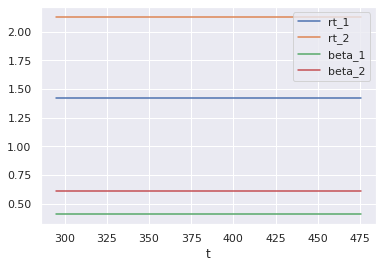

In [108]:
plt.figure()
history.rt_1.plot()
history.rt_2.plot()

history.beta_1.plot()
history.beta_2.plot()
plt.legend()
plt.show()

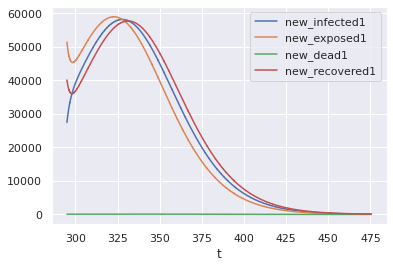

In [109]:
history.new_infected1.plot()
history.new_exposed1.plot()
history.new_dead1.plot()
history.new_recovered1.plot()
plt.legend()

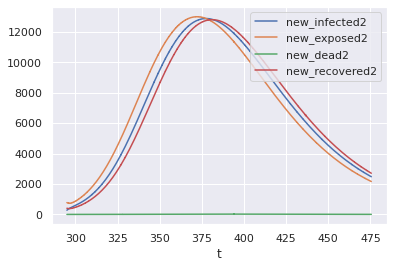

In [110]:
history.new_infected2.plot()
history.new_exposed2.plot()
history.new_dead2.plot()
history.new_recovered2.plot()
plt.legend()

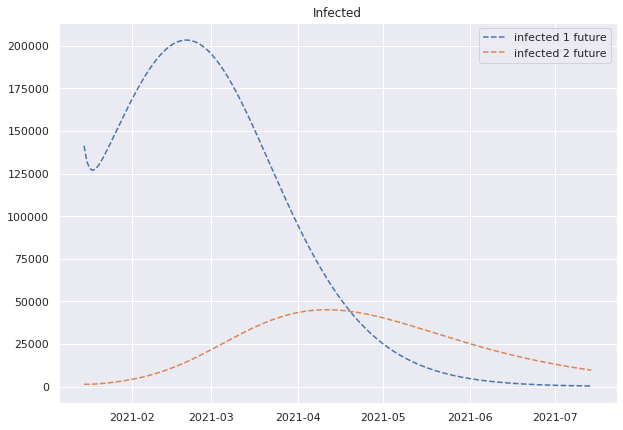

In [111]:
plt.figure(figsize=(10, 7))
plt.plot(future_dates, future_I1, label='infected 1 future', linestyle='--')
plt.plot(future_dates, future_I2, label='infected 2 future', linestyle='--')
plt.legend()
plt.title('Infected')
plt.show()

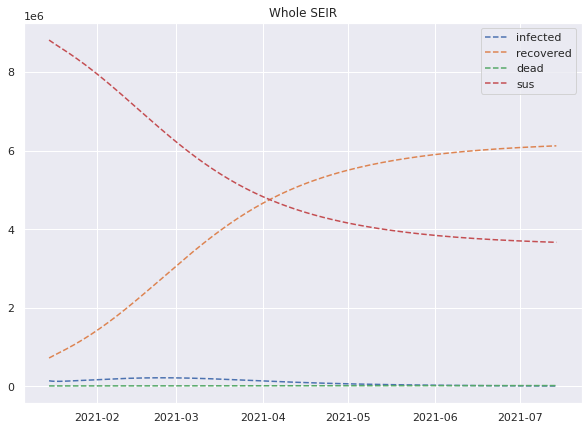

In [118]:
plt.figure(figsize=(10, 7))
plt.plot(future_dates, future_I1 + future_I2, label='infected', linestyle='--')
plt.plot(future_dates, future_R, label='recovered', linestyle='--')
plt.plot(future_dates, future_D, label='dead', linestyle='--')
plt.plot(future_dates, future_S, label='sus', linestyle='--')
plt.legend()
plt.title('Whole SEIR')
plt.show()